# Preliminary

### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
# print(physical_devices)

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Import data

In [5]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
# dataset.head()

(68528, 7)


In [6]:
# dataset.info()

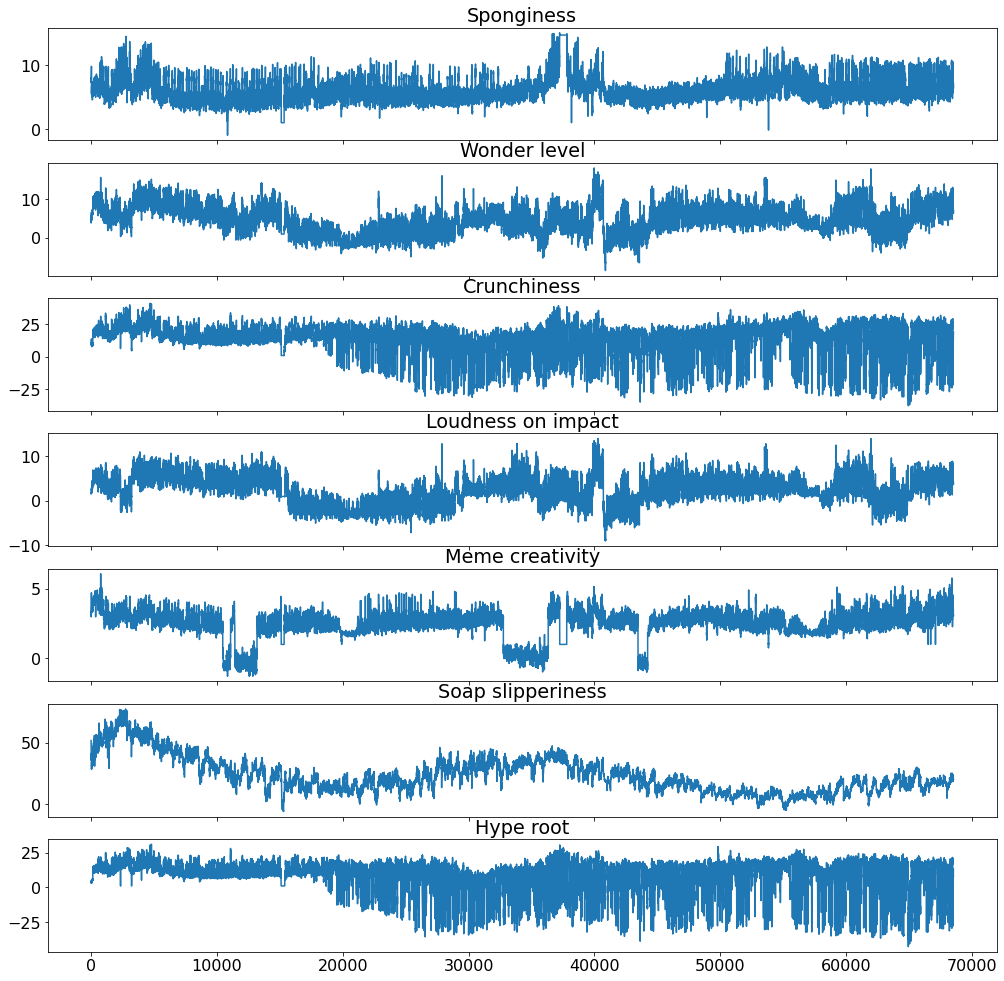

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

inspect_dataframe(dataset, dataset.columns)

(67528, 7) (1000, 7)


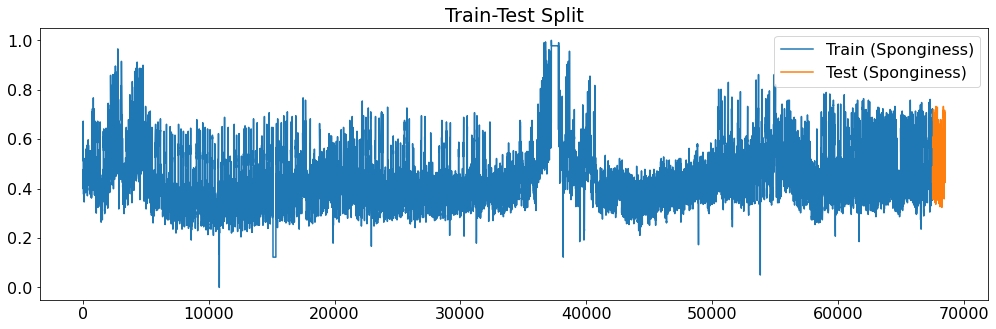

In [8]:
# Normalize both features and labels
X_min = dataset.min()
X_max = dataset.max()

test_size = 1000
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
# plt.plot(X_validation_raw.Sponginess, label='Valid (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [9]:
window = 400
stride = 1

In [10]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 400, 7)

In [11]:
def augbuild_seq(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)

    # ################
    # # AUGMENTATION #
    # ################

    # self.x_epoch = self.x_epoch.to_numpy()
    # self.y_epoch = self.y_epoch.to_numpy()

    # if self.which_subset == 'training':
    #   my_augmenter = (
    #       # TimeWarp() * 5  @ 0.1 # random time warping 5 times in parallel
    #       # + Crop(size=300)  # random crop subsequences with length 300
    #       Quantize(n_levels=[10, 20, 30]) @ 0.2 # random quantize to 10-, 20-, or 30- level sets
    #       + Drift(max_drift=(0.1, 0.5)) @ 0.1  # with 80% probability, random drift the signal up to 10% - 50%
    #       + Reverse() @ 0.1  # with 50% probability, reverse the sequence
    #   )

    #   X_aug, Y_aug = my_augmenter.augment(self.x_epoch, self.y_epoch)
    #   # print(X_aug.shape)
    #   # print(Y_aug.shape)
    #   # plot(X_aug, Y_aug)

    #   self.x_epoch = pd.DataFrame(X_aug)
    #   self.y_epoch = pd.DataFrame(Y_aug)

    return dataset, labels

In [12]:
#This function divide all the subsequences
#Telescope: how many samples we want to predict in the future
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [13]:
target_labels = dataset.columns
# telescope = 200
telescope = 1

In [14]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
# X_valid, y_valid = build_sequences(X_validation_raw, target_labels, window, stride, telescope)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [15]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

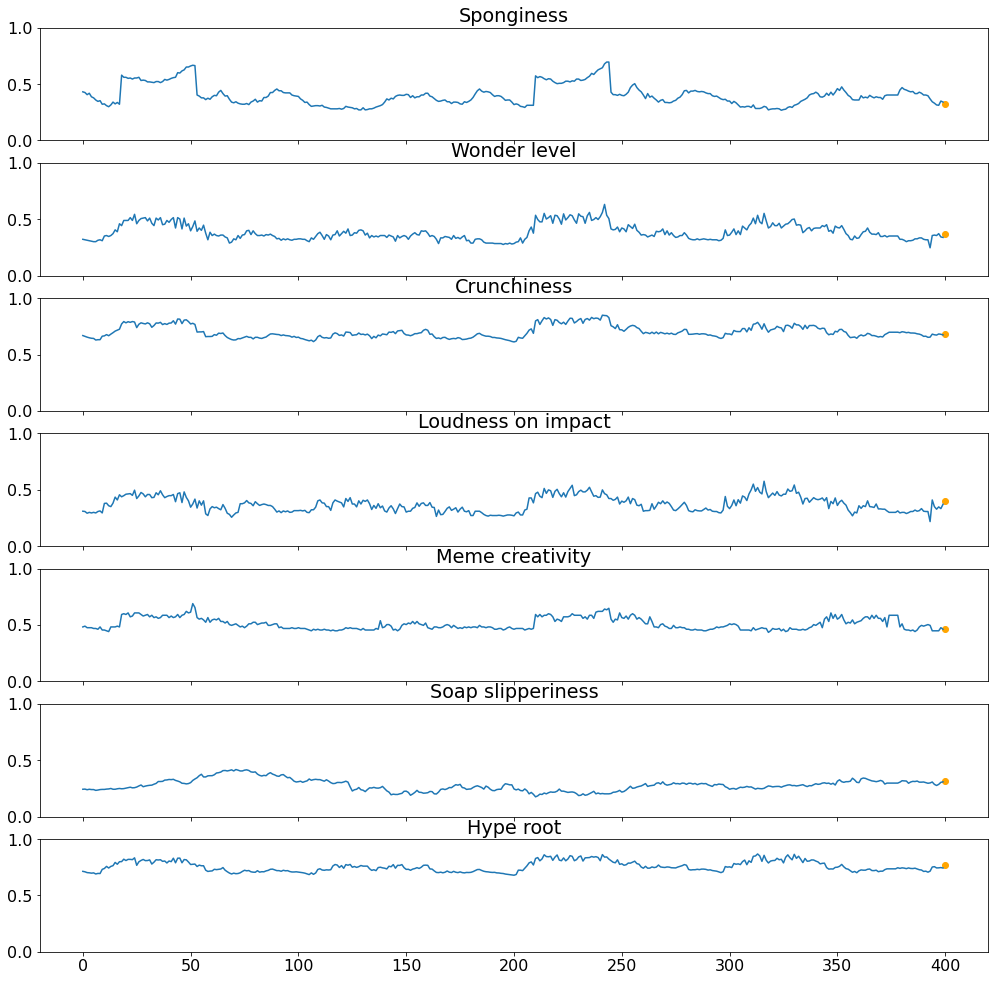

In [16]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

# Model

In [17]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200

In [18]:
from keras.layers.merge import concatenate

def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn1 = tfkl.Conv1D(8, 2, padding='same', activation='relu')(input_layer)
    # cnn1 = tfkl.BatchNormalization()(cnn1)
    cnn1 = tfkl.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = tfkl.Conv1D(16, 2, padding='same', activation='relu')(cnn1)
    # cnn1 = tfkl.BatchNormalization()(cnn1)
    cnn1 = tfkl.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = tfkl.Conv1D(32, 2, padding='same', activation='relu')(cnn1)
    # cnn1 = tfkl.BatchNormalization()(cnn1)
    cnn1 = tfkl.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = tfkl.Conv1D(64, 2, padding='same', activation='relu')(cnn1)
    # cnn1 = tfkl.BatchNormalization()(cnn1)
    cnn1 = tfkl.MaxPool1D(pool_size=2)(cnn1)
    # cnn1 = tfkl.Conv1D(128, 2, padding='same', activation='relu')(cnn1)
    # # cnn1 = tfkl.BatchNormalization()(cnn1)
    cnn1 = tfkl.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = tfkl.Flatten()(cnn1)
    # cnn1 = tfkl.GlobalAveragePooling1D()(cnn1)

    # dense = tfkl.Dropout(0.4)(cnn1)
    
    # dense = tfkl.LSTM(128, activation="relu", return_sequences=True) (dense)
    # dense = tfkl.LSTM(128, activation="relu") (dense)

    
    # dense = tfkl.Dense(256, activation='relu')(dense)
    # dense = tfkl.Dropout(0.4)(dense)
    dense = tfkl.Dense(512, activation='relu')(cnn1)
    dense = tfkl.Dropout(0.3)(dense)
    dense = tfkl.Dense(256, activation='relu')(dense)
    dense = tfkl.Dropout(0.3)(dense)
    dense = tfkl.Dense(32, activation='relu')(dense)
    # dense = tfkl.Dropout(0.4)(dense)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(dense)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_shape[-1]))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 400, 7)]          0         
                                                                 
 conv1d (Conv1D)             (None, 400, 8)            120       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 200, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 16)           272       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           1056  

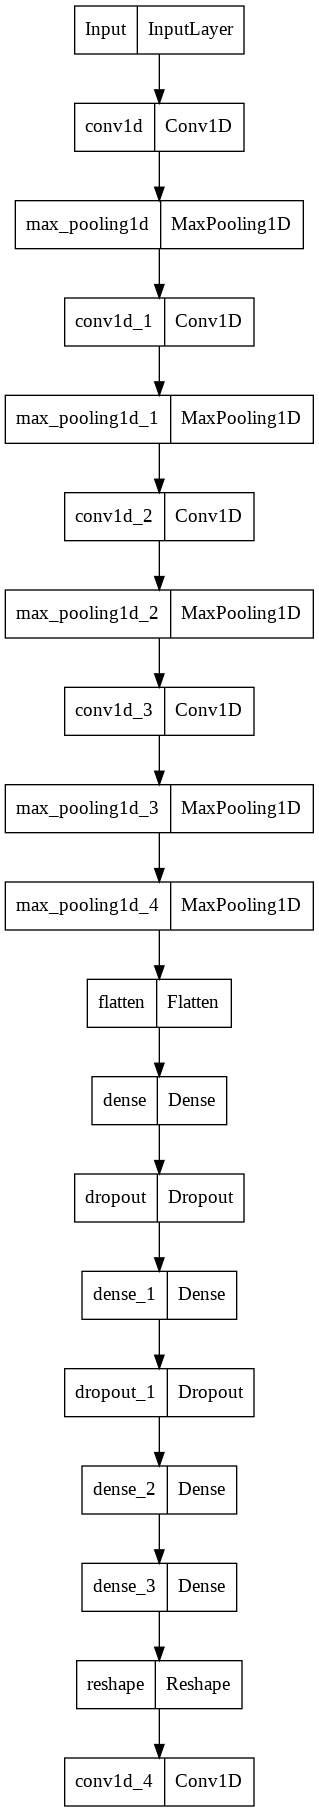

In [19]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [20]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
60/60 [==============================] - 14s 38ms/step - loss: 0.1134 - mae: 0.2630 - val_loss: 0.0703 - val_mae: 0.2104 - lr: 0.0010
Epoch 2/200
60/60 [==============================] - 2s 26ms/step - loss: 0.0425 - mae: 0.1598 - val_loss: 0.0175 - val_mae: 0.0985 - lr: 0.0010
Epoch 3/200
60/60 [==============================] - 2s 26ms/step - loss: 0.0183 - mae: 0.1040 - val_loss: 0.0140 - val_mae: 0.0908 - lr: 0.0010
Epoch 4/200
60/60 [==============================] - 1s 25ms/step - loss: 0.0161 - mae: 0.0986 - val_loss: 0.0138 - val_mae: 0.0845 - lr: 0.0010
Epoch 5/200
60/60 [==============================] - 2s 26ms/step - loss: 0.0151 - mae: 0.0956 - val_loss: 0.0132 - val_mae: 0.0831 - lr: 0.0010
Epoch 6/200
60/60 [==============================] - 2s 25ms/step - loss: 0.0142 - mae: 0.0925 - val_loss: 0.0120 - val_mae: 0.0817 - lr: 0.0010
Epoch 7/200
60/60 [==============================] - 2s 25ms/step - loss: 0.0132 - mae: 0.0887 - val_loss: 0.0116 - val_mae: 0.07

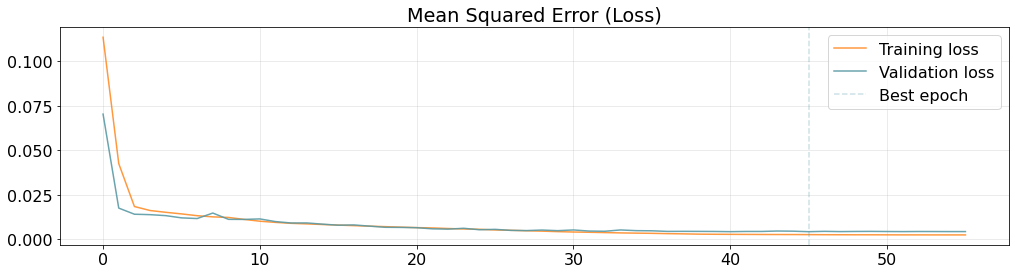

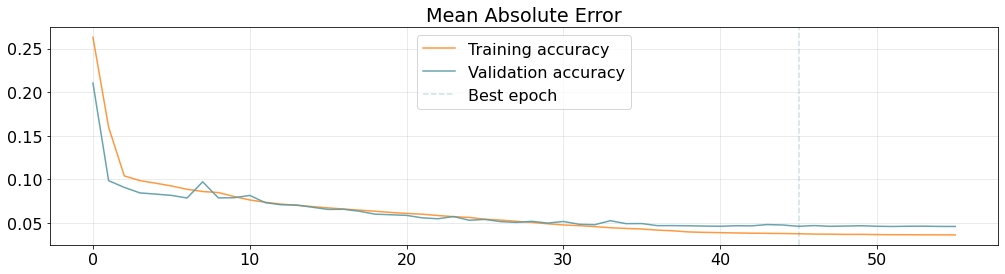

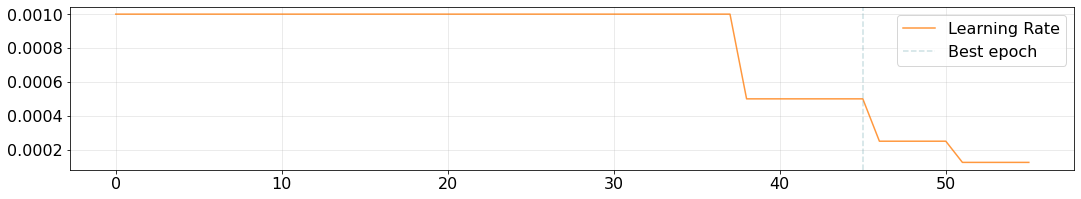

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Save model

In [22]:
model.save("Challenge2CNN.h5")

In [23]:
# model = tf.keras.models.load_model('hw2_model_v7.0.1.h5')

### Test

In [24]:
X_valid_to_predict = dataset.iloc[-test_size:]
print(X_valid_to_predict.shape)

XXX = dataset.iloc[:-test_size]
print(XXX.shape)

(1000, 7)
(67528, 7)


In [25]:
X_valid_to_predict = tf.convert_to_tensor(X_valid_to_predict)  

XXX_to_ = tf.convert_to_tensor(XXX)  

In [26]:
import math

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'Challenge2CNN.h5'))

    def predict(self, X, window=200, stride=10, telescope=100, to_predict=864):
        # Normalize both features and labels
        col_max = np.max(X, axis=0)
        col_min = np.min(X, axis=0)
        X_norm = np.divide(X - col_min, col_max - col_min)
        X = X_norm[-window:]
        X = np.expand_dims(X, axis=0)

        out = np.array([])
        
        for i in range(int(math.ceil(to_predict / stride))):
          pred = self.model.predict(X)
          pred = np.array(pred)

          X = np.concatenate((X[0], pred[0][:stride]), axis=0)
          X = np.expand_dims(X, axis=0)
          if i != 0:
            out = np.concatenate((out, pred[0][:stride]), axis=0)
          else:
            out = pred[0][:stride]

          X = X[0][-window:]
          X = np.expand_dims(X, axis=0)

        out = out[:to_predict]
        out = np.multiply(out, col_max - col_min)
        out = out + col_min
        out = tf.convert_to_tensor(out)
        return out

In [27]:
mod = model('/content')
window = 400
stride = 1
telescope = 1

In [28]:
pred = mod.predict(XXX_to_, window=window, stride=stride, telescope=telescope, to_predict=1000)

In [29]:
print(pred.shape)

(1000, 7)


In [30]:
mean_squared_error = tfk.metrics.mse(X_valid_to_predict.numpy().flatten(),pred.numpy().flatten())
mean_absolute_error = tfk.metrics.mae(X_valid_to_predict.numpy().flatten(),pred.numpy().flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=20.060421795622503>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.5044790890852875>)

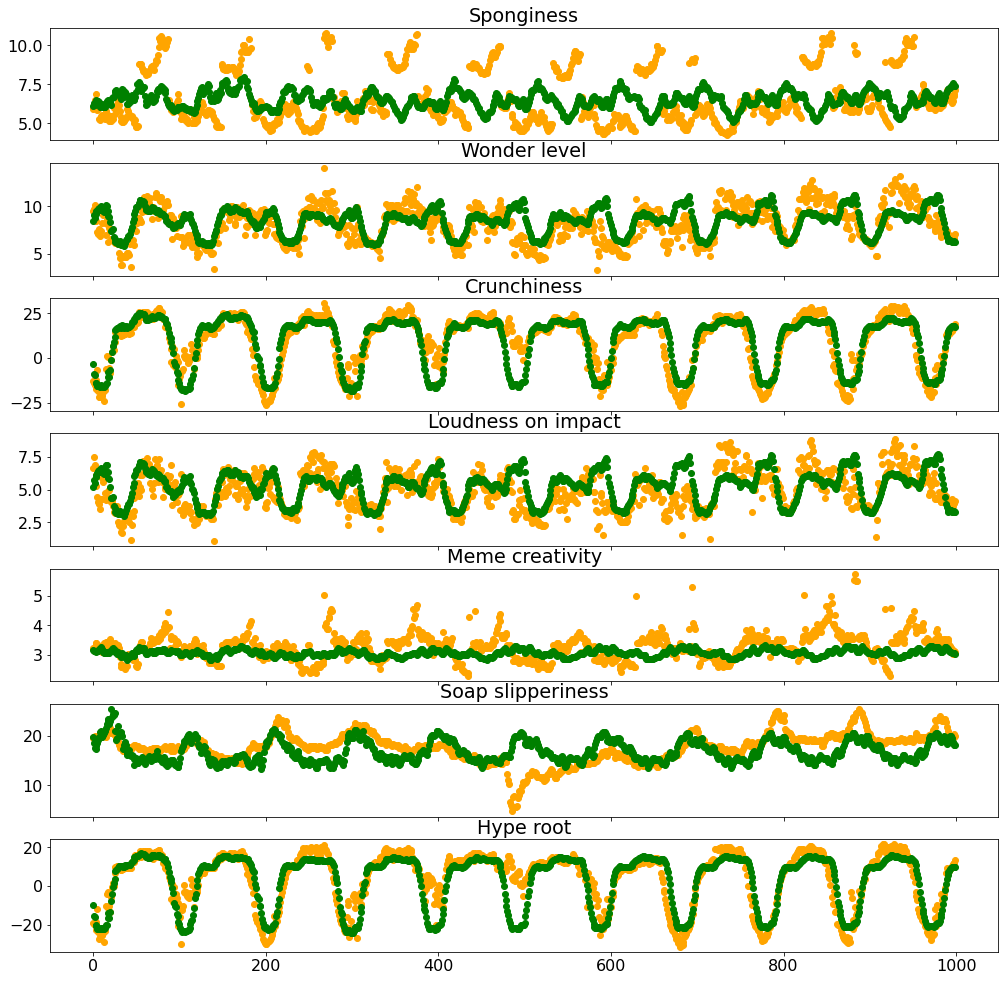

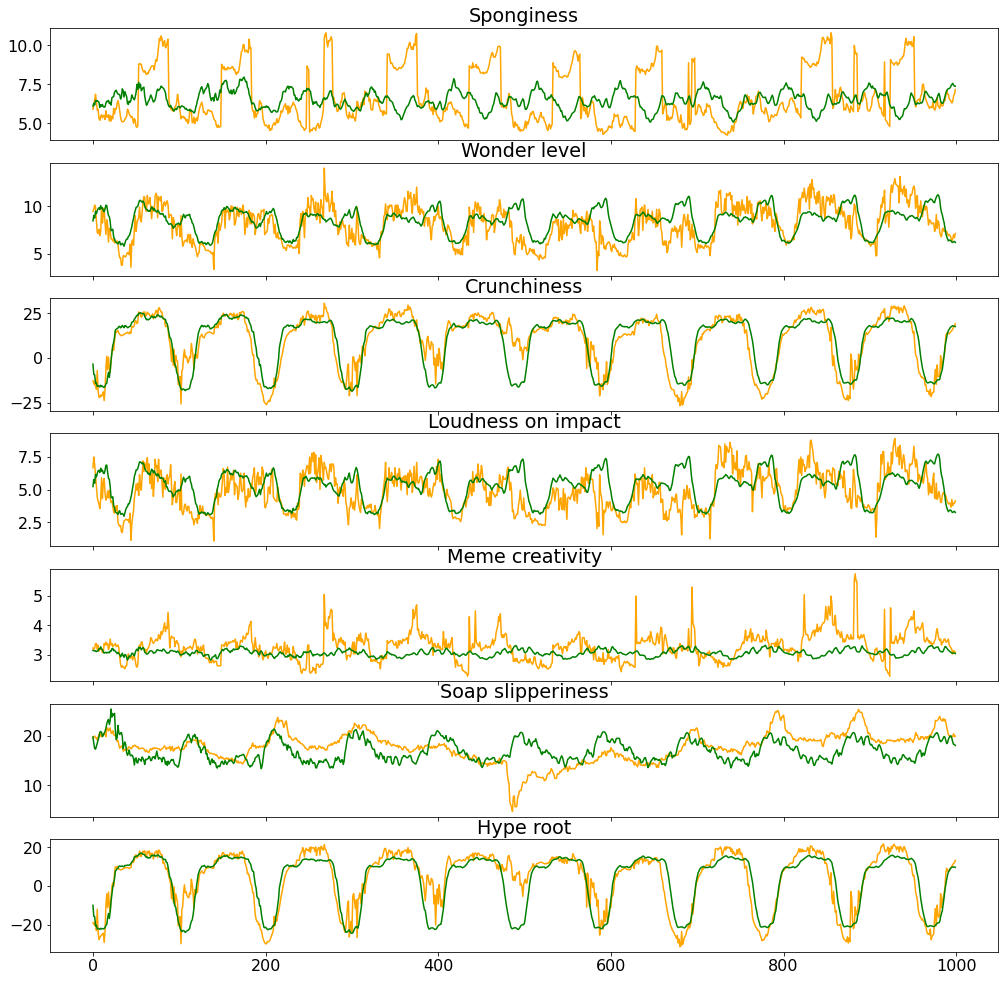

In [31]:
def inspect_multivariate_prediction_test_scatter(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        # axs[i].plot(np.arange(len(X[:,i])), X[:,i])
        axs[i].scatter(np.arange(len(X[:,i])), y[:,i], color='orange')
        axs[i].scatter(np.arange(len(X[:,i])), pred[:,i], color='green')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

def inspect_multivariate_prediction_test_plot(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        # axs[i].plot(np.arange(len(X[:,i])), X[:,i])
        axs[i].plot(np.arange(len(X[:,i])), y[:,i], color='orange')
        axs[i].plot(np.arange(len(X[:,i])), pred[:,i], color='green')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

inspect_multivariate_prediction_test_scatter(X_valid_to_predict, X_valid_to_predict, pred, target_labels, 1000, 0)
inspect_multivariate_prediction_test_plot(X_valid_to_predict, X_valid_to_predict, pred, target_labels, 1000, 0)